In [1]:
%matplotlib inline
#import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
#import theano
#import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc, mean_squared_error, roc_curve, roc_auc_score, accuracy_score



import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import os

import sys
sys.path.insert(0, '/Users/user/PycharmProjects/statrethink_course_in_pymc3')
sys.path.insert(0, '/Users/user/PycharmProjects/COVID19-ISRAEL')

In [2]:
fig_dir = '/Users/user/Desktop/Graduate/Tel_Aviv_University_Courses/Uri_Shalit/project/figures'

# Data proccesing 

In [3]:
# bangladesh v2 data
dir_path = '/Users/user/Downloads/BD_2014_DHS_09162020_1231_152120/BDBR72DT'
suffix = 'BDBR72FL.DTA'
path = os.path.join(dir_path, suffix)
dv2 = pd.read_stata(path)

In [4]:
print(f' there are {dv2.shape[0]} surveys with {dv2.shape[1]} features')

 there are 43772 surveys with 1159 features


In [5]:
dv2.drop_duplicates(keep='first', inplace=True)

In [6]:
print(f' There are {dv2.shape[0]} surveys after droping duplicates')

 There are 43772 surveys after droping duplicates


In [7]:
# v025 : rural urban
# v106 : No education, Primary, Secondary, and Higher
# V312 : Current contraceptive method
# v313 : modern method, a traditional method, or a folkloric method
# v315 : month started taking contraceptive
# v316 : year started taking contraceptive
# v701 : The current or most recent husband or partner's highest level of education attended
# v445 : bmi To produce the BMI divide by 100. The BMI has not been adjusted for pregnant women.
# v717 : occupation : Standardized respondent's occupation groups.
# v605 : want children : Desire for more children is a constructed variable classifying respondents
# v213 : pregnant
# v206 : Total number of sons who have died
# v207 : Total number of daughters who have died
# v130 : religion
# V136 : Total number of household members is the number of usual residents plus the number of visitors who slept in the house the previous night
column_dict = {'v010':'yob', 'v012':'age', 'v020':'ever_married',
               'v025':'urban','v106':'education',  'v201':'children', 
               'v312':'contraceptive_current', 'v313': 'contraceptive_type',
              'caseid':'id', "v701": 'education_husband', "v445":"bmi", "v717": 'occupation',
              'v605': 'want_children', 'v213':'pregnant', 'v130':'religion', 'v136': 'household_residents'}

In [8]:
d2 = dv2[[c for c in column_dict.keys()]]
d2 = d2.rename(columns=column_dict).copy()
d2['dead_children'] = dv2.v206 + dv2.v207
d2['Y'] = np.where(d2.contraceptive_current != 'not using',1,0)
d2['urban_bol'] = np.where(d2.urban == 'urban',1,0)
d2['pregnant'] = np.where(d2.pregnant == 'yes',1,0)

d2['id'] = (dv2['caseid'].astype(str)
            .apply(lambda x: x.split(' '))
            .apply(lambda x: ''.join(x))
            .astype(int))
edu_dict = {'no education':0, 'primary':1, 'secondary':2, 'higher':3}
d2['education_ord'] = d2.education.replace(edu_dict)
d2['education_husband_ord'] = d2.education_husband.replace(edu_dict)
print(d2.shape[0])
d2 = d2[~d2.education_husband_ord.isna()]
print(d2.shape[0])

43772
43769


In [9]:
bmi_list = d2.bmi.unique().tolist()
bmi_list.remove(bmi_list[3])
bmi_list.remove('flagged cases')
d2 = d2[d2.bmi.isin(bmi_list)]  
d2.bmi = d2.bmi.astype(int) / 100 

In [10]:
print(d2.shape[0])

43361


In [11]:
d2 = pd.merge(d2.reset_index(), pd.get_dummies(d2[['occupation']].reset_index()).astype(int), on='index')
d2 = pd.merge(d2, pd.get_dummies(d2[['want_children']].reset_index()).astype(int), on='index')
d2 = pd.merge(d2, pd.get_dummies(d2[['religion']].reset_index()).astype(int), on='index')

In [12]:
print(d2.shape[0])

42578


### Decide Treatment

In [13]:
# Secondary education

d2['T'] = np.where((d2.education_ord >=2) ,1,0)
higher = False
title = 'Treatment is Secondary education'
d2['Secondary Education'] = np.where((d2.education_ord ==2) ,1,0)

# Higher education
# d2['T'] = np.where((d2.education_ord ==3) ,1,0)
# d2['Secondary Education'] = np.where((d2.education_ord ==2) ,1,0)
# higher = True
# title = 'Treatment is Higher education'

In [14]:
print(f' there are {d2.id.nunique()} unique women in the survey with {d2.shape[0]} surveys')

 there are 15524 unique women in the survey with 42578 surveys


In [15]:
d2_dup = d2[d2.duplicated(subset='id',keep=False)]

In [16]:
print(f' there are {d2_dup.id.nunique()} women with multiple surveys')

 there are 11700 women with multiple surveys


##### We will drop duplicates on the limited columns

In [17]:
d2.drop_duplicates(keep='first', inplace=True)

In [18]:
print(f' there are {d2.shape[0]} unique surveys of {d2.id.nunique()}')

 there are 42578 unique surveys of 15524


In [19]:
d2_dup = d2[d2.duplicated(subset='id',keep=False)]

In [20]:
print(f' there are {d2_dup.id.nunique()} women with multiple surveys after droping duplicates')

 there are 11700 women with multiple surveys after droping duplicates


In [21]:
tmp = d2_dup.groupby('id').education_ord.count().reset_index()
tmp2 = tmp[tmp.duplicated(keep=False)]
print(f' There are {tmp2.shape[0]} women who changed their education during the time of the survey')

 There are 0 women who changed their education during the time of the survey


In [22]:
tmp = d2_dup.groupby('id').Y.count().reset_index()
tmp2 = tmp[tmp.duplicated(keep=False)]
print(f'  there are {tmp2.shape[0]} women who changed her contraceptive use between surveys')

  there are 0 women who changed her contraceptive use between surveys


In [23]:
d2.drop_duplicates(subset='id',keep='first', inplace=True)
print(f'We are left with {d2.shape[0]} surveys of {d2.id.nunique()} women')

We are left with 15524 surveys of 15524 women


# Data description

In [24]:
from src.Table1.table1_global import make_table1
from src.Table1.defs import *

In [25]:
d2.columns

Index(['index', 'yob', 'age', 'ever_married', 'urban', 'education', 'children',
       'contraceptive_current', 'contraceptive_type', 'id',
       'education_husband', 'bmi', 'occupation', 'want_children', 'pregnant',
       'religion', 'household_residents', 'dead_children', 'Y', 'urban_bol',
       'education_ord', 'education_husband_ord', 'occupation_not working',
       'occupation_professional/technical/managerial', 'occupation_sales',
       'occupation_agricultural - self employed',
       'occupation_agricultural - employee',
       'occupation_household and domestic', 'occupation_services',
       'occupation_skilled manual', 'occupation_unskilled manual',
       'want_children_wants within 2 years',
       'want_children_wants after 2+ years',
       'want_children_wants, unsure timing', 'want_children_undecided',
       'want_children_wants no more',
       'want_children_sterilized (respondent or partner)',
       'want_children_declared infecund', 'religion_islam',
       

In [26]:
TABLE_COLS = ['yob', 'age',  'children','dead_children','pregnant','household_residents',  'bmi', 'urban_bol',
              'Secondary Education', 'T', 'Y']

TABLE_LABELS =['Year of birth', 'Age', 'Number of children', 'Dead children','Pregnant' ,
               'Number of household residents', 'BMI', 'Urban','Secondary education',
               'Secondary or higher education', 'Using contraception']

TABEL_COLS_TYPE = ['continuous']*len(TABLE_COLS)

TX_labels = {'1': 'Using contraception', '0': 'Not using contraception'}

TX_col = 'Y'

In [27]:
table1 = (
    make_table1(d2, TABLE_COLS, TABLE_LABELS, TABEL_COLS_TYPE, TX_col, TX_labels, decimals=2).dropna(axis=1))
table1.columns = ['All patients', 'Not using contraception' ,'Using contraception']

In [28]:
round(table1,2)

,All patients,Not using contraception,Using contraception
N,"15,524","5,818 (37.48%)","9,706 (62.52%)"
Year of birth,"1,981.63 (8.84)","1,979.84 (9.76)","1,982.71 (8.05)"
Age,32.07 (8.83),33.86 (9.75),31.0 (8.04)
Number of children,2.71 (1.62),2.8 (1.81),2.66 (1.5)
Dead children,0.25 (0.6),0.32 (0.69),0.2 (0.53)
Pregnant,0.04 (0.19),0.1 (0.3),0.0 (0.0)
Number of household residents,5.38 (2.51),5.33 (2.75),5.41 (2.35)
BMI,22.39 (4.16),22.24 (4.31),22.48 (4.07)
Urban,0.33 (0.47),0.3 (0.46),0.34 (0.48)
Secondary education,0.36 (0.48),0.33 (0.47),0.38 (0.49)


In [29]:
if higher:
    table1.to_csv(os.path.join(fig_dir,'table1.csv'))
else:
    table1.to_csv(os.path.join(fig_dir,'table1_sec_and_higher.csv'))

In [30]:
education_table = d2[['Y','education_ord']].groupby('education_ord').Y.sum().reset_index()
education_table['education_ord_all_sum'] = d2[['Y','education_ord']].groupby('education_ord').Y.count()
education_table['not_Y'] = education_table.education_ord_all_sum - education_table.Y
education_table['Y_prop'] = education_table.Y / education_table.education_ord_all_sum 
education_table

,education_ord,Y,education_ord_all_sum,not_Y,Y_prop
0,0,2166,3888,1722,0.557099
1,1,2947,4708,1761,0.625956
2,2,3708,5647,1939,0.656632
3,3,885,1281,396,0.690867


In [31]:
print(f' 69% of higher education use contraception')

 69% of higher education use contraception


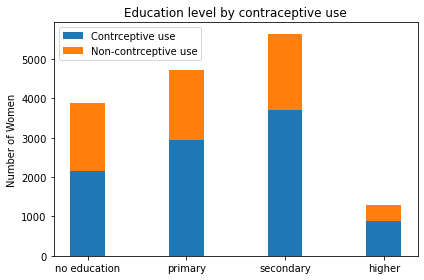

In [32]:

width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(education_table.education_ord, education_table.Y, width)
p2 = plt.bar(education_table.education_ord, education_table.not_Y, width,
             bottom=education_table.Y)

plt.ylabel('Number of Women')
plt.title('Education level by contraceptive use')
plt.xticks(education_table.education_ord, ('no education', 'primary', 'secondary', 'higher'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Contrceptive use', 'Non-contrceptive use'))

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'Education_level_by_contraceptive_use.png'))

## missing pie chart...

# Helper functions

In [33]:
def calc_propensity_score_sklearn_LR(X,T):

    model = LogisticRegression(max_iter=500)
    ps_model = model.fit(X=X, y=T)
    pscores = ps_model.predict_proba(X)[:,1]
    
    return ps_model, pscores
    
def plot_pscores(data, title='propensity score of data LR'):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=plt.figaspect(0.5))
      
    labels = [0,1]
    data_0 = data[data['T']==0]
    data_1 = data[data['T']==1]
    N_0 = data_0.shape[0]
    N_1 = data_1.shape[0]

    pscores_treated = data_1.ps
    ax = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax, cut=3)
    pscores_not_treated = data_0.ps
    ax = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax)
    ax.set_title(title)
    ax.legend(loc="best")
    
    fig.savefig(os.path.join(fig_dir, title+'.png'))

In [34]:
d2.columns

Index(['index', 'yob', 'age', 'ever_married', 'urban', 'education', 'children',
       'contraceptive_current', 'contraceptive_type', 'id',
       'education_husband', 'bmi', 'occupation', 'want_children', 'pregnant',
       'religion', 'household_residents', 'dead_children', 'Y', 'urban_bol',
       'education_ord', 'education_husband_ord', 'occupation_not working',
       'occupation_professional/technical/managerial', 'occupation_sales',
       'occupation_agricultural - self employed',
       'occupation_agricultural - employee',
       'occupation_household and domestic', 'occupation_services',
       'occupation_skilled manual', 'occupation_unskilled manual',
       'want_children_wants within 2 years',
       'want_children_wants after 2+ years',
       'want_children_wants, unsure timing', 'want_children_undecided',
       'want_children_wants no more',
       'want_children_sterilized (respondent or partner)',
       'want_children_declared infecund', 'religion_islam',
       

In [35]:
cols_to_drop = ['index', 'ever_married', 'urban','education','contraceptive_current',
                'contraceptive_type','id','occupation', 'religion',
                 'want_children','education_ord','education_husband']

cols_to_drop.append('Secondary Education')
d22 = d2.drop(columns=cols_to_drop)
# d22 = d2[['yob', 'age','children','T', 'urban_bol', 'Y']]

In [36]:
X1 = d22.drop(columns=['T','Y']).copy()
T1 = d22['T'] 
Y1 = d22['Y']

In [37]:
scale_columns = ['yob', 'age', 'children', 'bmi',
       'household_residents', 'dead_children','education_husband_ord']
X1[scale_columns] = preprocessing.scale(X1[scale_columns])

In [38]:
X1.columns

Index(['yob', 'age', 'children', 'bmi', 'pregnant', 'household_residents',
       'dead_children', 'urban_bol', 'education_husband_ord',
       'occupation_not working',
       'occupation_professional/technical/managerial', 'occupation_sales',
       'occupation_agricultural - self employed',
       'occupation_agricultural - employee',
       'occupation_household and domestic', 'occupation_services',
       'occupation_skilled manual', 'occupation_unskilled manual',
       'want_children_wants within 2 years',
       'want_children_wants after 2+ years',
       'want_children_wants, unsure timing', 'want_children_undecided',
       'want_children_wants no more',
       'want_children_sterilized (respondent or partner)',
       'want_children_declared infecund', 'religion_islam',
       'religion_hinduism', 'religion_buddhism', 'religion_christianity',
       'religion_other'],
      dtype='object')

## Propensity Score - using Logistic Regression  

In [39]:
ps_model, pscores = calc_propensity_score_sklearn_LR(X=X1, T=T1)
data1_copy = d22.copy()
data1_copy['ps'] = pscores

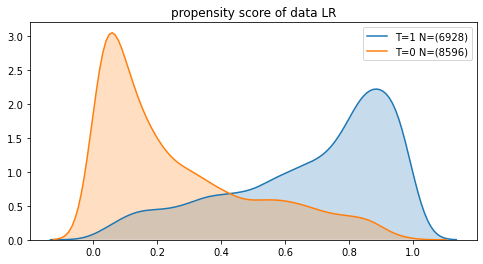

In [40]:
plot_pscores(data=data1_copy)

# Matching 

In [41]:
def plot_pscores2(datasets, titles=['propensity score of data LR','propensity score of data2 LR']):
    ncols = len(datasets)
    fig, ax = plt.subplots(nrows=1,ncols=ncols, figsize=plt.figaspect(0.5))
    for i, data in enumerate(datasets):      
        labels = [0,1]
        data_0 = data[data['T']==0]
        data_1 = data[data['T']==1]
        N_0 = data_0.shape[0]
        N_1 = data_1.shape[0]
        
        pscores_treated = data_1.ps
        ax[i] = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax[i])
        pscores_not_treated = data_0.ps
        ax[i] = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].legend(loc="best")
        
        fig.suptitle(title, fontsize=14)
        fig.savefig(os.path.join(fig_dir, 'ps before and after matching' +title+ '.png'))

In [42]:
def find_propensity_score_matches(X, TX_col, pscore_col, caliper=0.25, distance='linear'):
    """
    Treatment group should be smaller
    """
    
    idx_A0 = X[TX_col]==0
    idx_A1 = X[TX_col]==1
    
    X_T1, X_T0 = X[idx_A1].copy(), X[idx_A0].copy()
    N1, N0 = len(X_T1), len(X_T0)
    g1, g0 = X_T1.loc[:,pscore_col].copy(),  X_T0.loc[:,pscore_col].copy()
    
    # get caliper_value (default is 0.25 logit stdevs
    caliper_value = caliper * logit(X[pscore_col]).std()

    # Randomly permute the smaller group to get order for matching
    g1_idx_order = np.random.permutation(g1.index)
    for g1_idx in g1_idx_order:
        
        if distance=='linear': # linear propensity score (on the logits)
            dist = np.abs(logit(g1[g1_idx]) - logit(g0))
        else: # regular propensity score
            dist = np.abs(g1[g1_idx] - g0)
        
        
        if dist.min() <= caliper_value:
            g0_idx = dist.idxmin()
            X_T1.loc[g1_idx, 'matched_control_idx'] = g0_idx
            X_T0.loc[g0_idx, 'matched_control_idx'] = g0_idx
            g0 = g0.drop(g0_idx)
        else:
            X_T1.loc[g1_idx, 'matched_control_idx'] = np.nan        
            
    X_matched = pd.concat([X_T1, X_T0])
    return X_matched

In [43]:
data_matched = find_propensity_score_matches(data1_copy, 'T', 'ps', caliper=0.25, distance='linear')
data_matched.dropna(subset=['matched_control_idx'],inplace=True)


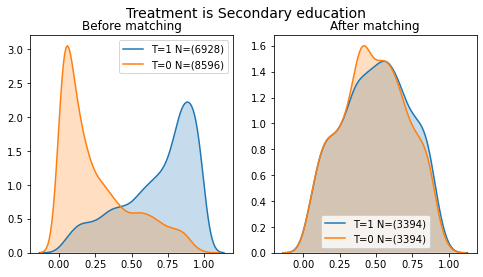

In [44]:
(plot_pscores2(datasets=[data1_copy,data_matched],
               titles=['Before matching','After matching']))


# Estimating ATE + ATT

In [45]:
ATE_pd = pd.DataFrame(columns=['Type','data1'])
ate_dict1 = {}

ATT_pd = pd.DataFrame(columns=['Type','data1'])
att_dict1 = {}

# Estimating ATT by Inverse Propensity Score Weighting (IPW)

Under ignorability for ATE we use the following formula:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{\frac{y_i t_i}{e_i}} - \frac{1}{n}\sum_{i=1}^{n}{\frac{y_i (1-t_i)}{1-e_i}}
\end{equation}

The weights described previously ($w_ATE= \frac{Z}{e} +\frac{1-Z}{1-e}$) permit estimation of the ATE. However, a different set of weights permit estimation of the average treatment effect in the treated (ATT): $w_ATT = Z +\frac{e \cdot(1−Z)}{1 − e}$[18]. These weights are obtained by multiplying the conventional weights by e , so that treated subjects receive a weight of one. Thus, the treated sample is being used as the reference population to which the treated and control samples are being standardized. While the current article is focused on the use of the ATE weights, the balance diagnostics discussed are equally applicable to situations in which the ATT weights are employed.

So We calculate:

\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{y_i t_i} - \frac{1}{n}\sum_{i=1}^{n}{y_i (1-t_i) \frac{e_i}{1-e_i}}
\end{equation}

In [46]:
ATE1 = (Y1*T1*(1/data1_copy.ps)).mean() - (Y1*(1-T1)*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")
ATT1 = (Y1*T1).mean() - (Y1*(1-T1)*(data1_copy.ps/(1-data1_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

att_dict1['IPW'] =ATT1
ate_dict1['IPW'] =ATE1

The estimated ATE for data1 using IPW is 0.03743753380565129
The estimated ATT for data1 using IPW is 0.028700587801248123


## ATE trimmed ps

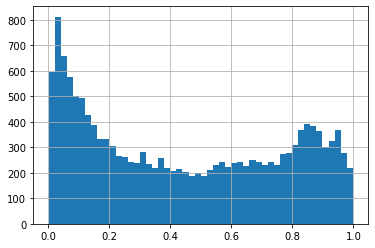

In [47]:
data1_copy.ps.hist(bins=50)

In [48]:
data_copy2 = data1_copy.copy()
data_copy2['Y'] = Y1
data_copy2['T'] = T1
data_trimmed = data1_copy[(data1_copy.ps >0.05) & (data1_copy.ps <0.95)]
Y2 = data_copy2['Y'] 
T2 = data_copy2['T'] 

ATE1 = (Y2*T2*(1/data_trimmed.ps)).mean() - (Y2*(1-T2)*(1/(1-data_trimmed.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")
ATT1 = (Y2*T2).mean() - (Y2*(1-T2)*(data_trimmed.ps/(1-data_trimmed.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

The estimated ATE for data1 using IPW is 0.04157224337956633
The estimated ATT for data1 using IPW is 0.009801238445806326


## normalize ps

In [49]:
n1 = 1/(T1/data1_copy.ps).sum()
n2 = 1/((1-T1)/(1-data1_copy.ps)).sum()
print(n1,n2)

6.327872590093378e-05 6.601595632968757e-05


In [50]:
ATE1 = n1*(Y1*T1*(1/data1_copy.ps)).mean() - n2*(Y1*(1-T1)*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")

The estimated ATE for data1 using IPW is 7.361734156401389e-07


# Estimating ATT using Matching

I use K-nearest neighbors as described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/ "..Nearest neighbor matching nearly always estimates the ATT, as it matches control individuals to the treated group and discards controls who are not selected as matches."

### Using Uber matching


In [ ]:
data1_copy.columns

In [ ]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

features = data1_copy.drop(columns=['Y','T'])
covariates = features.columns.tolist()

matched1 = psm.match(data=data1_copy,treatment_col='T',score_cols=['ps'])

In [ ]:
ATT1 = (matched1.Y*matched1['T'] - matched1.Y*(1-matched1['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1

### Using my code

In [51]:
ATT1 = (data_matched.Y*data_matched['T'] - data_matched.Y*(1-data_matched['T'])).mean()
print(f"The estimated ATT for data1 using 1:1 matching on ps is {ATT1}")
att_dict1['1:1 ps matching'] =ATT1

The estimated ATT for data1 using 1:1 matching on ps is 0.019004124926340602


# Estimating ATE + ATT using S-Learner

S-learner (single): fit a model with $t$ as feature on the entire sample:
\begin{equation}
y \approx \hat{f}(x,t) \\
ATE \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,0)}
\end{equation}

In [52]:
train1, test1 = train_test_split(d22,test_size=0.33)

x_train1, t_train1, y_train1 = train1.drop(columns=['T','Y']), train1['T'],train1['Y']
x_test1, t_test1, y_test1 = test1.drop(columns=['T','Y']), test1['T'],test1['Y']


In [53]:
d22.columns

Index(['yob', 'age', 'children', 'bmi', 'pregnant', 'household_residents',
       'dead_children', 'Y', 'urban_bol', 'education_husband_ord',
       'occupation_not working',
       'occupation_professional/technical/managerial', 'occupation_sales',
       'occupation_agricultural - self employed',
       'occupation_agricultural - employee',
       'occupation_household and domestic', 'occupation_services',
       'occupation_skilled manual', 'occupation_unskilled manual',
       'want_children_wants within 2 years',
       'want_children_wants after 2+ years',
       'want_children_wants, unsure timing', 'want_children_undecided',
       'want_children_wants no more',
       'want_children_sterilized (respondent or partner)',
       'want_children_declared infecund', 'religion_islam',
       'religion_hinduism', 'religion_buddhism', 'religion_christianity',
       'religion_other', 'T'],
      dtype='object')

## Logistic Regression

In [54]:
sc = preprocessing.StandardScaler()

x_train1[scale_columns] = sc.fit_transform(x_train1[scale_columns])
x_test1[scale_columns] = sc.fit_transform(x_test1[scale_columns])

In [55]:
LogReg_clf = LogisticRegression(max_iter=3000)
LogReg_clf.fit(x_train1.join(t_train1),y_train1)

LogisticRegression(max_iter=3000)

In [56]:
LogReg_clf.coef_

array([[ 0.19045865, -0.41216492,  0.35046176,  0.15079024, -5.25753935,
        -0.03976896, -0.23263066,  0.17958745, -0.01516186, -0.61069602,
        -0.1901719 , -0.26971842, -0.07879822, -0.22796646, -0.81091684,
        -0.44513786, -0.38326839, -0.02541936,  0.01563443, -0.11843117,
        -0.21333648, -0.38944021, -0.01891853, -0.05613944, -0.13467762,
         0.02998726,  0.25647041, -0.34719942, -0.08444353,  0.15635602,
         0.12470267]])

In [57]:
accuracy = accuracy_score(LogReg_clf.predict(x_test1.join(t_test1)),y_test1)

In [58]:
print(f"accuracy on the test set with LR is {round(accuracy,2)}")

accuracy on the test set with LR is 0.7


In [59]:
cols_to_drop = ['T', 'Y']
d22_scaled = d22.copy()
d22_scaled[scale_columns] = sc.fit_transform(d22_scaled[scale_columns])
X11 = d22_scaled.drop(columns=cols_to_drop)

In [60]:
X11t = X11.copy()
X11t['T']=1

X11nt = X11.copy()
X11nt['T']=0


In [61]:
ATE1 = (LogReg_clf.predict(X11t)-LogReg_clf.predict(X11nt)).mean()
print(f"The estimated ATE using S-learner (LR) is {ATE1}")
ate_dict1['S-learner (LR)'] =ATE1

The estimated ATE using S-learner (LR) is 0.03839216696727647


In [62]:
pdate = pd.DataFrame.from_dict(ate_dict1,orient='index', columns=['ATE'])
round(pdate,4)

,ATE
IPW,0.0374
S-learner (LR),0.0384


## ATT S-Learner estimation

In [63]:
cols_to_drop = ['T', 'Y']
d22_scaled = d22.copy()
d22_scaled[scale_columns] = sc.fit_transform(d22_scaled[scale_columns])

In [64]:
X11 = d22_scaled[d22_scaled['T']==1].drop(columns=cols_to_drop)
Y11 = d22_scaled[d22_scaled['T']==1].Y

X11t = X11.copy()
X11t['T']=1

X11nt = X11.copy()
X11nt['T']=0

In [65]:
ATT1 = (LogReg_clf.predict(X11t)-LogReg_clf.predict(X11nt)).mean()
print(f"The estimated ATT using S-learner (LR) is {ATT1}")
att_dict1['S-learner (LR)'] =ATT1

The estimated ATT using S-learner (LR) is 0.023239030023094687


In [66]:
pdatt = pd.DataFrame.from_dict(att_dict1,orient='index', columns=['ATT'])
round(pdatt,4)

,ATT
IPW,0.0287
1:1 ps matching,0.0190
S-learner (LR),0.0232


In [67]:
pdatt.to_csv(os.path.join(fig_dir,'att_table_second_and_higher_education.csv'))

In [68]:
pdate.to_csv(os.path.join(fig_dir,'ate_table_second_and_higher_education.csv'))

Note that both in the ATE and ATT estimates the S-Learner estimates are lower, this comes from the fact that in the S-learner method, the effect of the treatment on the prediction of the model can get washed out or attributed to other covariates. This is especially true when we do not model the interactions with other covariates. While the absolute value of the coefficient for the treatment was highest among all covariates (0.0082), I believe this is the reason for this lower estimate. 